In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import date
import calendar

In [29]:
cab = pd.read_csv("cab_rides.csv")
weather = pd.read_csv("weather.csv")

In [7]:
cab.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [8]:
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [9]:
def create_dummy(row):
    if row["surge_multiplier"] == 1:
        return 0
    return 1

In [10]:
cab["surge"] = cab.apply(lambda row: create_dummy(row), axis = 1)
cab.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,surge
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,0
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,0
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,0
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,0
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,0


In [11]:
# convert the datetime fields from epoch to datetime
cab['timestamp'] = pd.to_datetime(cab['time_stamp'], unit='ms')
cab['date_hour'] = cab['timestamp'].dt.strftime('%Y-%m-%d:%H.%M.%S')
weather['timestamp'] = pd.to_datetime(weather['time_stamp'], unit='s')
weather['date_hour'] = weather['timestamp'].dt.strftime('%Y-%m-%d:%H.%M.%S')
    
# drop redundant fields 
cabrides = cab.drop('time_stamp', axis=1)
weather = weather.drop('time_stamp', axis=1)

In [12]:
cab.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,surge,timestamp,date_hour
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,0,2018-12-16 09:30:07.890,2018-12-16:09.30.07
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,0,2018-11-27 02:00:23.677,2018-11-27:02.00.23
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,0,2018-11-28 01:00:22.198,2018-11-28:01.00.22
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,0,2018-11-30 04:53:02.749,2018-11-30:04.53.02
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,0,2018-11-29 03:49:20.223,2018-11-29:03.49.20


In [13]:
weather.head()

,temp,location,clouds,pressure,rain,humidity,wind,timestamp,date_hour
0,42.42,Back Bay,1.0,1012.14,0.1228,0.77,11.25,2018-12-16 23:45:01,2018-12-16:23.45.01
1,42.43,Beacon Hill,1.0,1012.15,0.1846,0.76,11.32,2018-12-16 23:45:01,2018-12-16:23.45.01
2,42.50,Boston University,1.0,1012.15,0.1089,0.76,11.07,2018-12-16 23:45:01,2018-12-16:23.45.01
3,42.11,Fenway,1.0,1012.13,0.0969,0.77,11.09,2018-12-16 23:45:01,2018-12-16:23.45.01
4,43.13,Financial District,1.0,1012.14,0.1786,0.75,11.49,2018-12-16 23:45:01,2018-12-16:23.45.01


In [14]:
merged = pd.merge(left=cab,
                  right=weather,
                  left_on=['source', 'date_hour'],
                  right_on=['location', 'date_hour'],
                  suffixes=('_ride', '_weather'))

# drop the merge fields -- location = source
drop_cols = ['date_hour', 'location']
merged = merged.drop(drop_cols, axis=1)

In [15]:
merged['rain'] = merged['rain'].fillna(0)

In [16]:
merged.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,surge,timestamp_ride,temp,clouds,pressure,rain,humidity,wind,timestamp_weather
0,0.55,Uber,1543426327706,South Station,Theatre District,7.0,1.0,74b72f4c-28bc-4640-a427-ec60b4b11f82,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,0,2018-11-28 17:32:07.706,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07
1,1.57,Uber,1543426327658,North End,Theatre District,18.0,1.0,e5aa2477-afb5-4b83-a69d-18ee7d2bfd1d,6c84fd89-3f11-4782-9b50-97c468b19529,Black,0,2018-11-28 17:32:07.658,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07
2,2.12,Lyft,1543426327658,Northeastern University,Theatre District,10.5,1.0,4d24470f-167a-4d1f-9cab-c123a0713491,lyft,Lyft,0,2018-11-28 17:32:07.658,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07
3,2.12,Lyft,1543426327658,Northeastern University,Theatre District,7.0,1.0,7902bfaf-5987-499b-9c04-222f4182c581,lyft_line,Shared,0,2018-11-28 17:32:07.658,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07
4,2.12,Lyft,1543426327658,Northeastern University,Theatre District,16.5,1.0,91129083-ed19-41fd-b16a-06c729ff0790,lyft_plus,Lyft XL,0,2018-11-28 17:32:07.658,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07


In [19]:
cab.shape

(693071, 13)

In [20]:
merged.shape

(3866, 19)

In [16]:
cab.name.value_counts()

UberXL          55096
WAV             55096
Black SUV       55096
Black           55095
Taxi            55095
UberX           55094
UberPool        55091
Lux             51235
Lyft            51235
Lux Black XL    51235
Lyft XL         51235
Lux Black       51235
Shared          51233
Name: name, dtype: int64

In [19]:
merged.name.value_counts()

Taxi            318
Black SUV       308
Black           307
UberPool        306
UberXL          306
Lyft XL         303
Lyft            302
Lux Black XL    296
WAV             296
Lux Black       296
UberX           293
Lux             270
Shared          265
Name: name, dtype: int64

In [2]:
def trans_var(row):
    if "XL" in row["name"]:
        return 1
    return 0

In [20]:
merged["xl"] = merged.apply(lambda row: trans_var(row), axis=1)
merged.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,surge,timestamp_ride,temp,clouds,pressure,rain,humidity,wind,timestamp_weather,xl
0,0.55,Uber,1543426327706,South Station,Theatre District,7.0,1.0,74b72f4c-28bc-4640-a427-ec60b4b11f82,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,0,2018-11-28 17:32:07.706,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07,0
1,1.57,Uber,1543426327658,North End,Theatre District,18.0,1.0,e5aa2477-afb5-4b83-a69d-18ee7d2bfd1d,6c84fd89-3f11-4782-9b50-97c468b19529,Black,0,2018-11-28 17:32:07.658,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07,0
2,2.12,Lyft,1543426327658,Northeastern University,Theatre District,10.5,1.0,4d24470f-167a-4d1f-9cab-c123a0713491,lyft,Lyft,0,2018-11-28 17:32:07.658,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07,0
3,2.12,Lyft,1543426327658,Northeastern University,Theatre District,7.0,1.0,7902bfaf-5987-499b-9c04-222f4182c581,lyft_line,Shared,0,2018-11-28 17:32:07.658,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07,0
4,2.12,Lyft,1543426327658,Northeastern University,Theatre District,16.5,1.0,91129083-ed19-41fd-b16a-06c729ff0790,lyft_plus,Lyft XL,0,2018-11-28 17:32:07.658,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07,1


<AxesSubplot:xlabel='xl', ylabel='price'>

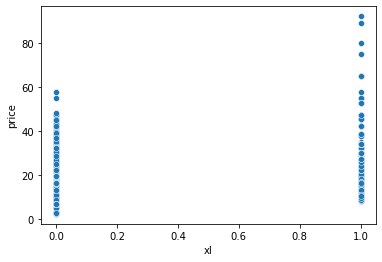

In [21]:
sns.scatterplot(data = merged, x = "xl", y = "price")

<AxesSubplot:xlabel='xl', ylabel='price'>

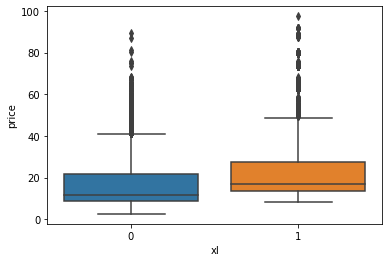

In [23]:
cab["xl"] = cab.apply(lambda row: trans_var(row), axis=1)
sns.boxplot(data = cab, x = "xl", y = "price")

In [25]:
cab.dropna(axis = 0, inplace = True)

In [26]:
weather.fillna(0, inplace = True)

In [65]:
weather_avg = weather.groupby('location').mean().reset_index()
weather_avg.drop(columns = 'time_stamp' , inplace = True)
weather_source = weather_avg.rename(columns =(lambda x :x + '_source'))       
weather_source.rename(columns= {'location_source' :'source'}, inplace = True)
weather_destination = weather_avg.rename(columns =(lambda x :x+'_destination'))       
weather_destination.rename(columns= {'location_destination' :'destination'} ,inplace = True)
data = cab\
       .merge(weather_source ,on ='source')\
       .merge(weather_destination ,on = 'destination')
data = data.drop('id'  , axis =1)

#binary encoding to cab_type

data['cab_type'] =data['cab_type'].replace({'Uber':1,'Lyft':0})

def one_hot_encode(df , column , prefix):
    dummy = pd.get_dummies(df[column] ,prefix = prefix)
    df = pd.concat([df , dummy] ,axis =1)
    #df =df.drop(column , axis =1)
    
    return df

data = one_hot_encode(data ,column =  'destination' , prefix = 'desti')
data = one_hot_encode(data ,column =  'source' , prefix = 'src')
data = one_hot_encode(data ,column =  'product_id' , prefix = 'pid')
data = one_hot_encode(data ,column =  'name' , prefix = 'nm')


In [39]:
data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,product_id,name,temp_source,...,nm_Lux Black,nm_Lux Black XL,nm_Lyft,nm_Lyft XL,nm_Shared,nm_Taxi,nm_UberPool,nm_UberX,nm_UberXL,nm_WAV
0,0.44,0,1544952607890,North Station,Haymarket Square,5.0,1.0,lyft_line,Shared,39.067897,...,0,0,0,0,1,0,0,0,0,0
1,0.44,0,1543284023677,North Station,Haymarket Square,11.0,1.0,lyft_premier,Lux,39.067897,...,0,0,0,0,0,0,0,0,0,0
2,0.44,0,1543366822198,North Station,Haymarket Square,7.0,1.0,lyft,Lyft,39.067897,...,0,0,1,0,0,0,0,0,0,0
3,0.44,0,1543553582749,North Station,Haymarket Square,26.0,1.0,lyft_luxsuv,Lux Black XL,39.067897,...,0,1,0,0,0,0,0,0,0,0
4,0.44,0,1543463360223,North Station,Haymarket Square,9.0,1.0,lyft_plus,Lyft XL,39.067897,...,0,0,0,1,0,0,0,0,0,0


In [66]:
data["id"] = data.index
data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,product_id,name,temp_source,...,nm_Lux Black XL,nm_Lyft,nm_Lyft XL,nm_Shared,nm_Taxi,nm_UberPool,nm_UberX,nm_UberXL,nm_WAV,id
0,0.44,0,1544952607890,North Station,Haymarket Square,5.0,1.0,lyft_line,Shared,39.067897,...,0,0,0,1,0,0,0,0,0,0
1,0.44,0,1543284023677,North Station,Haymarket Square,11.0,1.0,lyft_premier,Lux,39.067897,...,0,0,0,0,0,0,0,0,0,1
2,0.44,0,1543366822198,North Station,Haymarket Square,7.0,1.0,lyft,Lyft,39.067897,...,0,1,0,0,0,0,0,0,0,2
3,0.44,0,1543553582749,North Station,Haymarket Square,26.0,1.0,lyft_luxsuv,Lux Black XL,39.067897,...,1,0,0,0,0,0,0,0,0,3
4,0.44,0,1543463360223,North Station,Haymarket Square,9.0,1.0,lyft_plus,Lyft XL,39.067897,...,0,0,1,0,0,0,0,0,0,4


In [67]:
addtl = data.loc[:,["id", "source", "destination", "name"]]
addtl

,id,source,destination,name
0,0,Haymarket Square,North Station,Shared
1,1,Haymarket Square,North Station,Lux
2,2,Haymarket Square,North Station,Lyft
3,3,Haymarket Square,North Station,Lux Black XL
4,4,Haymarket Square,North Station,Lyft XL
...,...,...,...,...
693066,693066,Financial District,Haymarket Square,Lux Black XL
693067,693067,Financial District,Haymarket Square,Shared
693068,693068,Financial District,Haymarket Square,Lux Black
693069,693069,Financial District,Haymarket Square,Lyft XL


In [68]:
data.drop(columns = ["source", "destination", "product_id", "name"], inplace = True)

In [47]:
data.head()

,distance,cab_type,time_stamp,price,surge_multiplier,temp_source,clouds_source,pressure_source,rain_source,humidity_source,...,nm_Lux Black XL,nm_Lyft,nm_Lyft XL,nm_Shared,nm_Taxi,nm_UberPool,nm_UberX,nm_UberXL,nm_WAV,id
0,0.44,0,1544952607890,5.0,1.0,39.067897,0.676711,1008.445239,0.059593,0.764837,...,0,0,0,1,0,0,0,0,0,0
1,0.44,0,1543284023677,11.0,1.0,39.067897,0.676711,1008.445239,0.059593,0.764837,...,0,0,0,0,0,0,0,0,0,1
2,0.44,0,1543366822198,7.0,1.0,39.067897,0.676711,1008.445239,0.059593,0.764837,...,0,1,0,0,0,0,0,0,0,2
3,0.44,0,1543553582749,26.0,1.0,39.067897,0.676711,1008.445239,0.059593,0.764837,...,1,0,0,0,0,0,0,0,0,3
4,0.44,0,1543463360223,9.0,1.0,39.067897,0.676711,1008.445239,0.059593,0.764837,...,0,0,1,0,0,0,0,0,0,4


In [69]:
x = data.drop('price', axis = 1)
y = data['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
print(x_train.shape , x_test.shape , y_train.shape , y_test.shape)

sc = StandardScaler()
sc.fit(x_train)

x_train2 = pd.DataFrame(sc.transform(x_train) ,columns =x.columns)
x_test2 =  pd.DataFrame(sc.transform(x_test) ,columns = x.columns)

(485149, 67) (207922, 67) (485149,) (207922,)


In [57]:
from sklearn.model_selection import train_test_split

In [70]:
train2, test2 = train_test_split(data, shuffle=True, train_size=0.7)

In [79]:
addtl

,id,source,destination,name
0,0,Haymarket Square,North Station,Shared
1,1,Haymarket Square,North Station,Lux
2,2,Haymarket Square,North Station,Lyft
3,3,Haymarket Square,North Station,Lux Black XL
4,4,Haymarket Square,North Station,Lyft XL
...,...,...,...,...
693066,693066,Financial District,Haymarket Square,Lux Black XL
693067,693067,Financial District,Haymarket Square,Shared
693068,693068,Financial District,Haymarket Square,Lux Black
693069,693069,Financial District,Haymarket Square,Lyft XL


In [78]:
test2.merge(addtl, how="right", on = "id")
test2

,distance,cab_type,time_stamp,price,surge_multiplier,temp_source,clouds_source,pressure_source,rain_source,humidity_source,...,nm_Lux Black XL,nm_Lyft,nm_Lyft XL,nm_Shared,nm_Taxi,nm_UberPool,nm_UberX,nm_UberXL,nm_WAV,id
120722,1.16,1,1543719180909,7.0,1.00,39.067897,0.676711,1008.445239,0.059593,0.764837,...,0,0,0,0,0,1,0,0,0,120722
142302,2.96,0,1543628892316,32.5,1.00,39.047744,0.679235,1008.459254,0.054688,0.763786,...,1,0,0,0,0,0,0,0,0,142302
104331,1.62,1,1544737209922,NaN,1.00,39.394092,0.677495,1008.438031,0.059537,0.755468,...,0,0,0,0,1,0,0,0,0,104331
75824,3.04,1,1543302741936,8.5,1.00,39.047744,0.679235,1008.459254,0.054688,0.763786,...,0,0,0,0,0,0,1,0,0,75824
330969,0.53,0,1545099303432,34.0,1.25,39.394092,0.677495,1008.438031,0.059537,0.755468,...,1,0,0,0,0,0,0,0,0,330969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321997,4.13,0,1543463948049,10.5,1.00,38.964379,0.679866,1008.453289,0.054863,0.767266,...,0,0,0,1,0,0,0,0,0,321997
589571,2.06,0,1543477084093,27.5,1.25,39.035315,0.676998,1008.442811,0.056542,0.765545,...,0,0,0,0,0,0,0,0,0,589571
537591,3.02,1,1543362681880,34.0,1.00,39.035315,0.676998,1008.442811,0.056542,0.765545,...,0,0,0,0,0,0,0,0,0,537591
545464,2.33,0,1543311022018,13.5,1.00,39.047285,0.677801,1008.448356,0.057097,0.765048,...,0,0,1,0,0,0,0,0,0,545464
